In [1]:
import sys
sys.path.append("/mnt/d/00_SARDARCHITECTLABS/projects/fscoreai-ml/")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from fscoreai.utils import utils
from fscoreai.loss import loss
from fscoreai.sample_data import sample_data
from sklearn.preprocessing import normalize
from sklearn.linear_model import LinearRegression

# One-Dimensional Data

In [3]:
X, y = sample_data.get_data(name='simulate_linear_data')
print(X.shape, y.shape)

(100, 1) (100,)


## SimpleLinear Regression with SkLearn

In [4]:
model_sklearn = LinearRegression(fit_intercept=True)
model_sklearn.fit(X,y)
print(model_sklearn.coef_, model_sklearn.intercept_)

[2.06896634] 0.9135935729613112


## Custom Simple Linear Regression

In [5]:
class SimpleLinearRegression():
    def __init__(self):
        self.coef_ = 0
        self.intercept_ = 0
    
    def fit_stat(self, X, y):
        # Closed-form Solution
            X_mean = np.mean(X, axis=0)
            y_mean = np.mean(y)
            self.coef_ = np.sum((X - X_mean).T*(y-y_mean), axis=1)/(np.sum((X - X_mean)**2, axis=0)) 
            self.intercept_ = y_mean - (self.coef_ * X_mean)
            return self
    
    def fit_grad(self, X, y, lr=1e-8, epochs=50):
        # Batch Gradient Descent Solution
            self.lr = lr  #   Learning rate
            self.epochs = epochs
            self.n, self.d = X.shape
            
            for epoch in range(self.epochs):
                for j in range(self.d):
                    y_pred = self.predict(X)
                    d_coef = - (2 / self.n) * np.sum((y - y_pred).dot(X[:,j])) #Derivative w.r.t. self.coef_
                    d_intercept = - (2 / self.n) * np.sum(y - y_pred) #Derivative w.r.t. self.intercept_
                    self.coef_ -=  self.lr * d_coef          #    Update self.coef_ 
                    self.intercept_ -=  self.lr * d_intercept  #    Update self.intercept_
            return self
        
    def predict(self, X):
        return np.dot(X, self.coef_) + self.intercept_

In [6]:
# Using Closed-form Solution
model_fscore_1 = SimpleLinearRegression()
model_fscore_1.fit_stat(X,y)
print(model_fscore_1.coef_, model_fscore_1.intercept_)

[2.06896634] [0.91359357]


In [7]:
# Using Batch Gradient Descent Solution
model_fscore_2 = SimpleLinearRegression()
model_fscore_2.fit_grad(X,y,lr=1e-6, epochs=50000)
print(model_fscore_2.coef_, model_fscore_2.intercept_)

2.214546965177562 0.9111545363313955


## Plotting the models

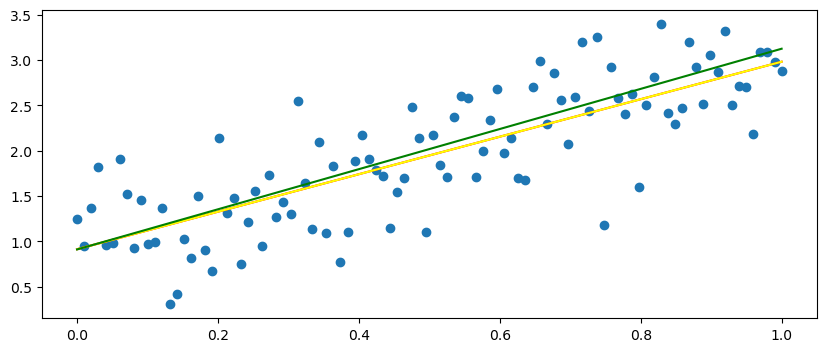

In [9]:
preds_sklearn = model_sklearn.predict(X)
preds_fscore_1 = model_fscore_1.predict(X)
preds_fscore_2 = model_fscore_2.predict(X)

plt.figure(figsize=(10,4))
plt.scatter(X, y)
plt.plot(X, preds_sklearn, color='red')
plt.plot(X, preds_fscore_1, color='yellow')
plt.plot(X, preds_fscore_2, color='green')

plt.show()

# Multi-Dimensional Data

In [10]:
from sklearn import datasets
diabetes = datasets.load_diabetes(as_frame=True)

In [11]:
diabetes['data']

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641
...,...,...,...,...,...,...,...,...,...,...
437,0.041708,0.050680,0.019662,0.059744,-0.005697,-0.002566,-0.028674,-0.002592,0.031193,0.007207
438,-0.005515,0.050680,-0.015906,-0.067642,0.049341,0.079165,-0.028674,0.034309,-0.018114,0.044485
439,0.041708,0.050680,-0.015906,0.017293,-0.037344,-0.013840,-0.024993,-0.011080,-0.046883,0.015491
440,-0.045472,-0.044642,0.039062,0.001215,0.016318,0.015283,-0.028674,0.026560,0.044529,-0.025930


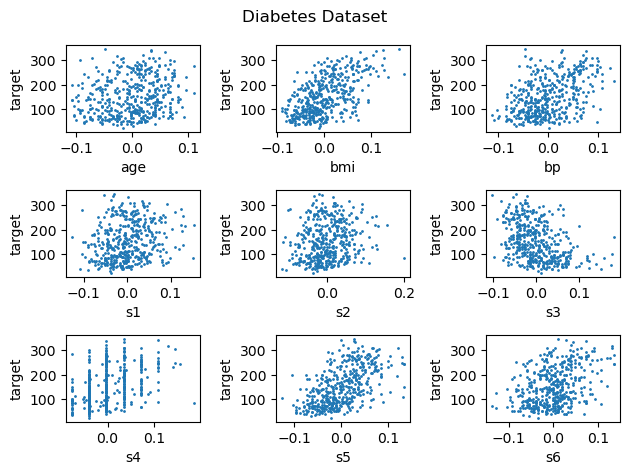

In [12]:
# Don't plot the sex data
features = diabetes['feature_names']
features.remove('sex')

# Plot
fig, axs = plt.subplots(3, 3)
fig.suptitle('Diabetes Dataset')
for i in range(3):
    for j in range(3):
        n = j + i * 3
        feature = features[n]
        axs[i, j].scatter(diabetes['data'][feature], diabetes['target'], s=1)
        axs[i, j].set_xlabel(feature)
        axs[i, j].set_ylabel('target')
plt.tight_layout()
plt.show()

In [13]:
X = diabetes['data'][['age','bmi','bp','s1','s2','s3','s4','s5','s6']].to_numpy()
y = diabetes['target'].to_numpy().reshape(-1,1)

## Custom Multiple Linear Regression

In [14]:
class MultipleLinearRegression():
    def __init__(self):
        self.betas = None
        self.coef_ = None
        self.intercept_ = None
        
        self.betas_history = {}
        self.loss_history = {}
        self.gradients_history = {}
    
    def fit_stat(self, X, y):
        # Closed-form Solution
        self.n, self.d = X.shape
        x_0 = np.ones((self.n, 1))
        x = np.hstack((x_0, X))
        self.betas = np.linalg.inv(np.dot(x.T, x)).dot(np.dot(x.T, y))

        self.intercept_ = self.betas[0]
        self.coef_ = self.betas[1:]
        return self
    
    def fit_grad(self, X, y, lr, iters):
        # Batch Gradient Descent Solution
        y = y.reshape(-1, 1)
        self.n, self.d = X.shape
        x_0 = np.ones((self.n, 1))
        x = np.hstack((x_0, X))

        # Initialize betas
        self.betas = np.random.randn(self.d + 1, 1)

        for i in range(iters):
            y_pred = np.dot(x, self.betas)
            delta_betas = 2 * np.dot(x.T, (y_pred - y))
            self.betas -= (lr * delta_betas)

            # Logging Loss
            self.gradients_history[i] = delta_betas
            b = self.betas.copy()
            self.betas_history[i] = b
            self.loss_history[i] = loss.mean_squared_error(y_pred, y)

        self.intercept_ = self.betas[0]
        self.coef_ = self.betas[1:]
        return self
        
    def predict(self, X):
        x_0 = np.ones((X.shape[0], 1))
        x = np.hstack((x_0, X))
        return np.dot(x, self.betas)

In [15]:
# Closed-form solution
model_fscore_1 = MultipleLinearRegression()
model_fscore_1.fit_stat(X,y)
print("Coef_:\n", model_fscore_1.coef_)
print("\nIntercept_:\n", model_fscore_1.intercept_)
print("\nMSE:\n",loss.mean_squared_error(y, model_fscore_1.predict(X)))

Coef_:
 [[ -33.17655557]
 [ 557.06057374]
 [ 276.08163793]
 [-712.80368975]
 [ 420.56485548]
 [ 139.51079371]
 [ 126.28020632]
 [ 756.36625515]
 [  48.91841452]]

Intercept_:
 [152.13348416]

MSE:
 2961.5033766486795


## Multiple Linear Regression with SkLearn

In [16]:
# SkLearn for Comparision
model_sklearn = LinearRegression(fit_intercept=True)
model_sklearn.fit(X,y)
print("Coef_:\n", model_sklearn.coef_)
print("\nIntercept_:\n", model_sklearn.intercept_)
print("\nMSE:\n",loss.mean_squared_error(y, model_sklearn.predict(X)))

Coef_:
 [[ -33.17655557  557.06057374  276.08163793 -712.80368975  420.56485548
   139.51079371  126.28020632  756.36625515   48.91841452]]

Intercept_:
 [152.13348416]

MSE:
 2961.5033766486795


# Linear Regression Batch Gradient Descent Analysis

In [35]:
model = MultipleLinearRegression()
model.fit_grad(X, y, lr=1e-3, iters=2000)
print("Coef_:\n", model.coef_)
print("\nIntercept_:\n", model.intercept_)
print("\nMSE:\n",loss.mean_squared_error(y, model.predict(X)))

Coef_:
 [[ -25.2761766 ]
 [ 545.0504497 ]
 [ 282.5229927 ]
 [ -38.96045653]
 [-126.5060349 ]
 [-153.25287271]
 [  85.18392833]
 [ 462.28036663]
 [  73.7461501 ]]

Intercept_:
 [152.13348416]

MSE:
 2982.7470292870557


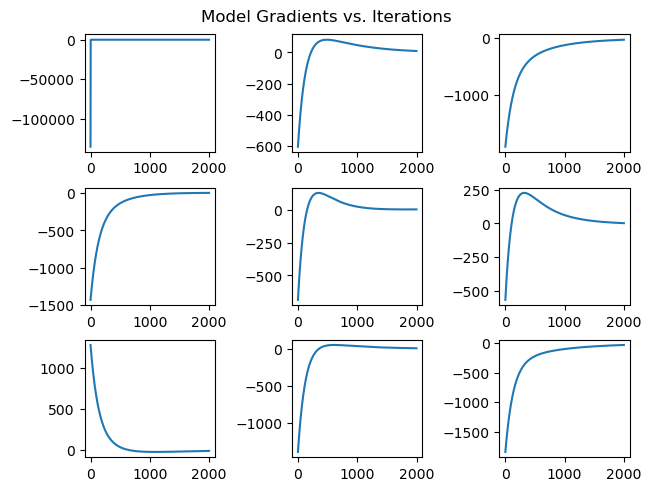

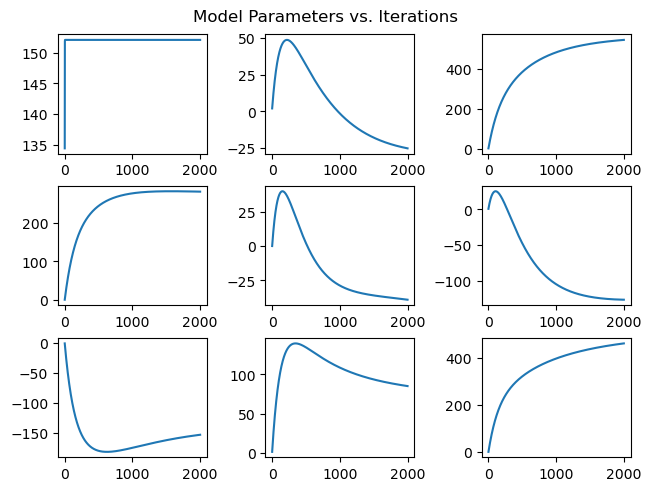

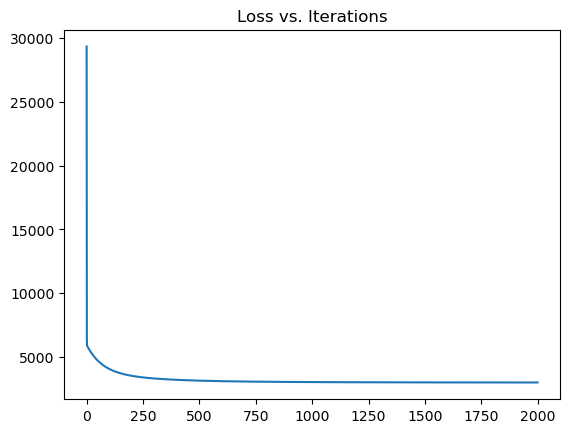

In [36]:
# Logging and visualizing stored training data
model_betas = np.array(list(model.betas_history.values()))
model_gradients = np.array(list(model.gradients_history.values()))
model_loss = np.array(list(model.loss_history.values()))

# Visualize Model Gradients
fig, axs = plt.subplots(3,3,constrained_layout=True)
fig.suptitle('Model Gradients vs. Iterations')
for i in range(3):
    for j in range(3):
        n = j + i * 3
        axs[i][j].plot(model.gradients_history.keys(), model_gradients[:, n])
plt.show()

# Visualize Model Parameters
fig, axs = plt.subplots(3, 3, constrained_layout = True)
fig.suptitle('Model Parameters vs. Iterations')
for i in range(3):
    for j in range(3):
        n = j + i * 3
        axs[i][j].plot(model.betas_history.keys(), model_betas[:, n])
plt.show()

# Visualize Model Loss
plt.plot(model.loss_history.keys(), model_loss)
plt.title("Loss vs. Iterations")
plt.show()

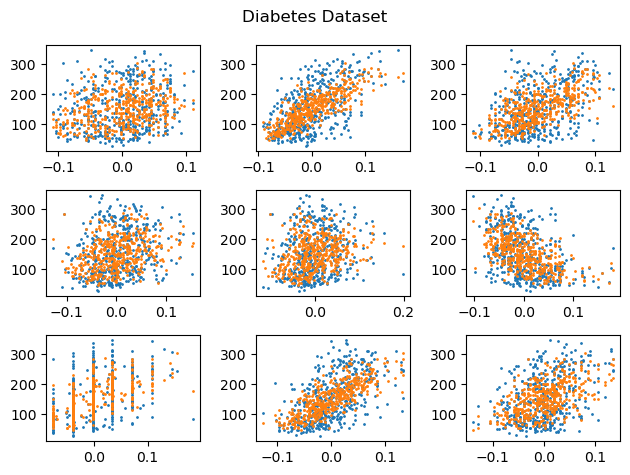

In [41]:
# Plot
fig, axs = plt.subplots(3, 3)
fig.suptitle('Diabetes Dataset')
for i in range(3):
    for j in range(3):
        n = j + i * 3
        axs[i][j].scatter(X[:, n], y, s=1)
        axs[i][j].scatter(X[:, n], model.predict(X), s=1)
plt.tight_layout()
plt.show()